In [22]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# %matplotlib inline
import sys
sys.path.append("../../notebooks")

import utils
utils.jpt_autoreload()
utils.jpt_full_width()
utils.jpt_suppress_warnings()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['font.size'] = 15
mpl.rcParams['font.family'] = 'Sans'
cmap = plt.cm.get_cmap('bwr')

import os, re, time
import pandas as pd
import numpy as np

from label_reports import get_chf_cohort, label_report
import negex
from regex_utils import WordMatch
from section_parser import section_text
from extract_findings import *

from tabulate import tabulate
from datasets import MimicCxrLabels, MimicCxrReader, MimicCxrBase

In [24]:
cxr_labels = MimicCxrLabels()
cxr_reader = MimicCxrReader()
meta_df = MimicCxrBase().get_meta_df()

TypeError: super(type, obj): obj must be an instance or subtype of type

In [25]:

import jax
from scipy.stats import spearmanr, pearsonr

def plt_correlation_between_labels(ax, y, F, title, finding_labels):
    from scipy.stats import spearmanr, pearsonr
    L = len(finding_labels)
    K = y.shape[1]
    cors = np.ones((L, K)); pvals = np.ones((L, K))
    for i, finding in enumerate(finding_labels):
        for j in range(K):
            cor, pval = spearmanr(F[:,i], y[:,j], nan_policy='omit')
            if cor == np.nan:
                print(f'F({i}), Y({j}) has cor=nan')
            cors = jax.ops.index_update(cors, jax.ops.index[i,j], cor)
            pvals = jax.ops.index_update(pvals, jax.ops.index[i,j], pval)
    for i in range(K):
        ax.errorbar(finding_labels, cors[:,i],
                    yerr=pvals[:,i], label=f'c={i}', alpha=.8)
    ax.set_ylabel('spearsmanr', fontsize=30)
    ax.set_xticklabels(finding_labels, rotation=-30, ha='left', fontsize=25)
    ax.legend()
    ax.set_title(f'Correlation: {title}', fontsize=30)
    ax.set_ylim((-1.1,1.1))
    ax.grid()
    
    
    
def plt_FY_frequency_heatmap(axs, y, F, finding_labels, xlabel='Y', ylabel='F'):
    
    M = F.shape[1]  # #finding
    C = y.shape[1]  # #classes/4
    y = np.argmax(y, -1).astype(np.int32) # onehot -> \Z
    
    freqs = []
    for c in range(C):
        ind = (y==c)
        Fc = F[ind]
        Fc0_cnt = np.sum(Fc==0, axis=0)
        Fc1_cnt = np.sum(Fc==1, axis=0)
        Fc_cnt = np.stack((Fc0_cnt, Fc1_cnt))
        freqs.append(Fc_cnt)

    # (F=0/1, M, C) 
    freqs = np.stack(freqs, axis=2)
    
    for c in range(C):
        ax = axs[c]
        
        ax.imshow(freqs[:,:,c].T, cmap='Greys')
        ax.set_title(f'{xlabel}={c}')
        ax.set_yticks(np.arange(M))
        if c == 0:
            ax.set_ylabel(ylabel)
            ax.set_yticklabels(finding_labels)
        for i in range(M):
            for j in range(2):
                text = ax.text(j, i, freqs[j,i,c], ha='center', va='center', color='r')

In [26]:
import yaml
from pprint import pprint

with open('keywords_v5.yml') as f:
    info = yaml.safe_load(f)
    
keywords = [v for k,v in info['keywords'].items()]
keywords = sum(keywords, [])
keywords


['pulmonary edema',
 'fluid overload',
 'acute cardiopulmonary process',
 'vascular congestion',
 'pulmonary vascular congestion',
 'vascular enlargement',
 'vascular plethora',
 'vascular engorgement',
 'vascular prominence',
 'cephalization',
 'hilar congestion',
 'hilar engorgement',
 'hilar prominence',
 'hilar infiltrates',
 'peribronchial cuffing',
 'bronchial cuffing',
 'bronchial wall thickening',
 'septal lines',
 'septal line',
 'septal thickening',
 'kerley',
 'b lines',
 'b-lines',
 'b line',
 'interstitial abnormality',
 'interstitial abnormalities',
 'interstitial marking',
 'interstitial markings',
 'interstitial process',
 'interstitial thickening',
 'interstitial infiltrates',
 'interstitial edema',
 'interstitial pulmonary edema',
 'air bronchograms',
 'parenchymal opacity',
 'parenchymal opacification',
 'parenchymal opacities',
 'parenchymal infiltrates',
 'airspace opacity',
 'airspace opacification',
 'airspace opacities',
 'alveolar opacity',
 'alveolar opacifica

In [14]:
# `meta_df` restrict to chf cohort
cohort = 'all'

chf_metadata_path = os.path.join('.', 'mimic_cxr_heart_failure', 'mimic_cxr_metadata_hf.tsv')
df_save_path = os.path.join('./', f'negex_findings_cohort={cohort}_v5.csv')

def get_chf_study_ids():
    meta_df = pd.read_csv(chf_metadata_path, sep='\t')
    meta_df = meta_df[meta_df['heart_failure'] == 1]
    study_ids = meta_df['study_id'].unique()
    return study_ids

if cohort == 'all':
    meta_df = MimicCxrBase().get_meta_df()
    study_ids = meta_df['study_id'].unique()
elif cohort == 'chf':
    meta_df = pd.read_csv(chf_metadata_path, sep='\t')
    meta_df = meta_df[meta_df['heart_failure'] == 1]
    study_ids = meta_df['study_id'].unique()

chf_study_ids = get_chf_study_ids()
print(f"#study_id = {len(study_ids)}")

print(cxr_reader.get_report(study_ids[10]))

#study_id = 218139
                                 FINAL REPORT
 HISTORY:  Recurrent vomiting, subjective fever and cough.
 
 TECHNIQUE:  Upright AP and lateral views of the chest.
 
 COMPARISON:  ___.
 
 FINDINGS:
 
 Lung volumes are low.  The heart size is normal.  The mediastinal and hilar
 contours are unremarkable.  New nodular opacities are clustered within the
 left upper lobe, and to a lesser extent, within the right upper lobe.  There
 is no pneumothorax or left-sided pleural effusion.  Pulmonary vascularity is
 within normal limits.  Postsurgical changes are noted in the right chest with
 partial resection of the right 6th rib, lateral right pleural thickening and
 chronic blunting of the costophrenic sulcus.  
 
 IMPRESSION:
 
 New nodular opacities within both upper lobes, left greater than right.
 Findings are compatible with metastases, as was noted in the lung bases on the
 subsequent CT of the abdomen and pelvis performed later the same day.



In [7]:
labels = {}
start = time.time()

for i, study_id in enumerate(study_ids):
    
    try:
        report = cxr_reader.get_report(study_id)
    except:
        continue

    label = extract_findings(report, keywords)
    labels[study_id] = label

    if i%1000 == 0:
        end = time.time()
        print(f'Iter={i}\tTime Elapsed={end-start:.3f}')
        start = time.time()
        
        
df = pd.DataFrame.from_dict(labels, orient='index', columns=keywords)
df = df.rename_axis('study_id').reset_index()
print(len(df))

Iter=0	Time Elapsed=0.023
Iter=1000	Time Elapsed=8.927
Iter=2000	Time Elapsed=7.936
Iter=3000	Time Elapsed=8.875
Iter=4000	Time Elapsed=8.743
Iter=5000	Time Elapsed=9.066
Iter=6000	Time Elapsed=8.843
Iter=7000	Time Elapsed=9.135
Iter=8000	Time Elapsed=10.132
Iter=9000	Time Elapsed=9.169
Iter=10000	Time Elapsed=9.049
Iter=11000	Time Elapsed=9.694
Iter=12000	Time Elapsed=9.237
Iter=13000	Time Elapsed=10.325
Iter=14000	Time Elapsed=10.363
Iter=15000	Time Elapsed=9.630
Iter=16000	Time Elapsed=9.777
Iter=17000	Time Elapsed=10.880
Iter=18000	Time Elapsed=11.837
Iter=19000	Time Elapsed=11.430
Iter=20000	Time Elapsed=10.283
Iter=21000	Time Elapsed=10.888
Iter=22000	Time Elapsed=10.269
Iter=23000	Time Elapsed=10.828
Iter=24000	Time Elapsed=10.599
Iter=25000	Time Elapsed=10.830
Iter=26000	Time Elapsed=10.205
Iter=27000	Time Elapsed=10.798
Iter=28000	Time Elapsed=10.968
Iter=29000	Time Elapsed=10.828
Iter=30000	Time Elapsed=11.156
Iter=31000	Time Elapsed=10.687
Iter=32000	Time Elapsed=10.628
Iter

In [6]:
df_output_path = './note_labelfinding_cohort=all_v5.csv'
# df.to_csv(df_output_path)
df = pd.read_csv(df_output_path, index_col=0)


In [7]:
C = cols_value_counts(df.iloc[:,1:])
print(tabulate(C, headers=['keywords/'] + [str(x) for x in list(C.columns)]))

keywords/                        0.0    1.0     nan
-----------------------------  -----  -----  ------
pulmonary edema                26559  24334  164200
fluid overload                   147   2788  212158
acute cardiopulmonary process  27751    121  187221
vascular congestion             8659  12984  193450
pulmonary vascular congestion   2481   8843  203769
vascular enlargement              11     99  214983
vascular plethora                  6    489  214598
vascular engorgement             380   2648  212065
vascular prominence                2    197  214894
cephalization                      4    442  214647
hilar congestion                  12    474  214607
hilar engorgement                  2    146  214945
hilar prominence                   2    304  214787
hilar infiltrates                  0     10  215083
peribronchial cuffing             12    364  214717
bronchial cuffing                  4    457  214632
bronchial wall thickening          1    394  214698
septal lines

In [8]:
## 1. merge synonyms
#
cols_merge = [synonyms for k, synonyms in info['keywords'].items() if len(synonyms)>1]

for cols in cols_merge:
    assert(len(cols)>=2)
    col_mergeto = cols[0]
    for col_mergefrom in cols[1:]:
        df = merge_2cols(df, col_mergefrom, col_mergeto)

import itertools
cols_drop = list(itertools.chain(*[x[1:] for x in cols_merge]))

for col in cols_drop:
    df = df.drop(col, 1)
    
C = cols_value_counts(df.iloc[:,1:])
print(tabulate(C, headers=['keywords/'] + [str(x) for x in list(C.columns)]))

keywords/                        0.0    1.0     nan
-----------------------------  -----  -----  ------
pulmonary edema                26559  24334  164200
fluid overload                   147   2788  212158
acute cardiopulmonary process  27751    121  187221
vascular congestion             9045  16350  189698
hilar congestion                  16    912  214165
peribronchial cuffing              4    829  214260
septal lines                      10    410  214673
interstitial abnormality         514   9320  205259
air bronchograms                  42    891  214160
parenchymal opacity             2838   7417  204838
nodular opacity                   17   2206  212870
bibasilar opacity                 34   5289  209770
perihilar opacity                 11   1579  213503
patchy opacity                     7   3850  211236
severe pulmonary edema             8   1056  214029


In [9]:
# 2. construct severity labels on study_id restricted to chf cohorts
#     - lvl 0 as negative class, e.g. label=0, 
#     - otherwise, assign most severe level (from keywords)
#
df['regex_label'] = np.nan

def assign_lvl0(row):
    
    lvl0 = np.any([row[k] == 0 for k in info['severity'][0]])
    lvl1 = np.any([row[k] == 1 for k in info['severity'][1]])
    lvl2 = np.any([row[k] == 1 for k in info['severity'][2]])
    lvl3 = np.any([row[k] == 1 for k in info['severity'][3]])
    lvls = np.array([lvl0,lvl1,lvl2,lvl3])
    ind = np.where(lvls==True)
    
    if len(ind[0]) == 0:
        return np.nan
    else:
        return ind[0][-1] # take most severe
    
        
df['regex_label'] = df.apply(assign_lvl0, axis=1)

C = cols_value_counts(df.iloc[:,1:])
print(tabulate(C, headers=['keywords/'] + [str(x) for x in list(C.columns)]))
# chf
# regex_label                     2589   2258   1755    859  207632
# all
# regex_label                    53017  15026   9252   8363  129435


keywords/                        0.0    1.0    2.0    3.0     nan
-----------------------------  -----  -----  -----  -----  ------
pulmonary edema                26559  24334      0      0  164200
fluid overload                   147   2788      0      0  212158
acute cardiopulmonary process  27751    121      0      0  187221
vascular congestion             9045  16350      0      0  189698
hilar congestion                  16    912      0      0  214165
peribronchial cuffing              4    829      0      0  214260
septal lines                      10    410      0      0  214673
interstitial abnormality         514   9320      0      0  205259
air bronchograms                  42    891      0      0  214160
parenchymal opacity             2838   7417      0      0  204838
nodular opacity                   17   2206      0      0  212870
bibasilar opacity                 34   5289      0      0  209770
perihilar opacity                 11   1579      0      0  213503
patchy opa

In [27]:

def plt_PFcondY_heatmap(ax, y, F, finding_labels, xlabel='Y', ylabel='F'):
    
    M = F.shape[1]  # #finding
    C = y.shape[1]  # #classes/4
    y = np.argmax(y, -1).astype(np.int32) # onehot -> \Z
    
    freqs = []
    for c in range(C):
        ind = (y==c)
        Fc = F[ind]
        Fc0_cnt = np.sum(Fc==0, axis=0)
        Fc1_cnt = np.sum(Fc==1, axis=0)
        Fc_cnt = np.stack((Fc0_cnt, Fc1_cnt))
        freqs.append(Fc_cnt)

    # (F=0/1, M, C) 
    freqs = np.stack(freqs, axis=2)
    freqs_sum = np.sum(freqs, axis=0)
    pFY = freqs[1,:,:]/np.sum(freqs, axis=0)
    pFY = pFY.squeeze()
    
    ax.imshow(pFY, cmap='Greys', vmin=0, vmax=1) # black=0, white=1
    ax.set_ylabel(ylabel)
    ax.set_xlabel('Y')
    ax.set_yticks(np.arange(M))
    ax.set_yticklabels(finding_labels)
    ax.set_title('P(F|Y)')
    
    cmap = plt.cm.get_cmap('Blues')
    cmap = cmap.reversed()
    
    for i in range(M):
        for j in range(C):
            color = cmap(pFY[i,j]*.8 if not np.isnan(pFY[i,j]) else 0)
            text = ax.text(j, i, f'{pFY[i,j]:.2f}\n{freqs[1,i,j]}/{freqs_sum[i,j]}',
                           ha='center', va='center', color=color, fontsize=15)
            
            
                

def plt_correlation_and_frequency(df):
    df = df[df['study_id'].isin(chf_study_ids)].copy()
    F = df[info['finding']].to_numpy()
    Y = df['regex_label'].to_numpy()
    ind = np.isnan(Y)
    F = F[~ind]; Y = Y[~ind]  # remove nan from Y... o.w. one_hot=[0,0,0,0]
    Y = jax.nn.one_hot(Y, 4)

    fig1, ax = plt.subplots(1,1,figsize=(15,8))
    plt_correlation_between_labels(ax, Y, F, 'y, F', info['finding'])
    fig1.tight_layout()
    
    fig2, axs = plt.subplots(1,4,figsize=(15,15),sharey=True)
    plt_FY_frequency_heatmap(axs, Y, F, info['finding'], xlabel='Y', ylabel='F')
    fig2.tight_layout()

    fig3, ax = plt.subplots(1,1,figsize=(15,15),sharey=True)
    plt_PFcondY_heatmap(ax, Y, F, info['finding'], xlabel='Y', ylabel='F')
    fig3.tight_layout()
    
    return fig1, fig2, fig3



/data/vision/polina/shared_software/miniconda3/envs/cxr/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


(<Figure size 1080x576 with 1 Axes>,
 <Figure size 1080x1080 with 4 Axes>,
 <Figure size 1080x1080 with 1 Axes>)

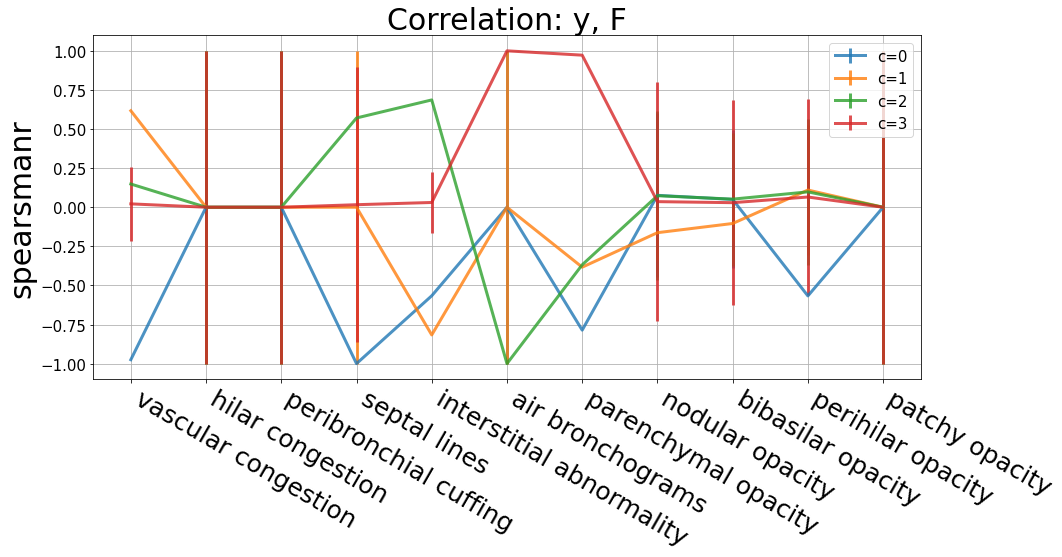

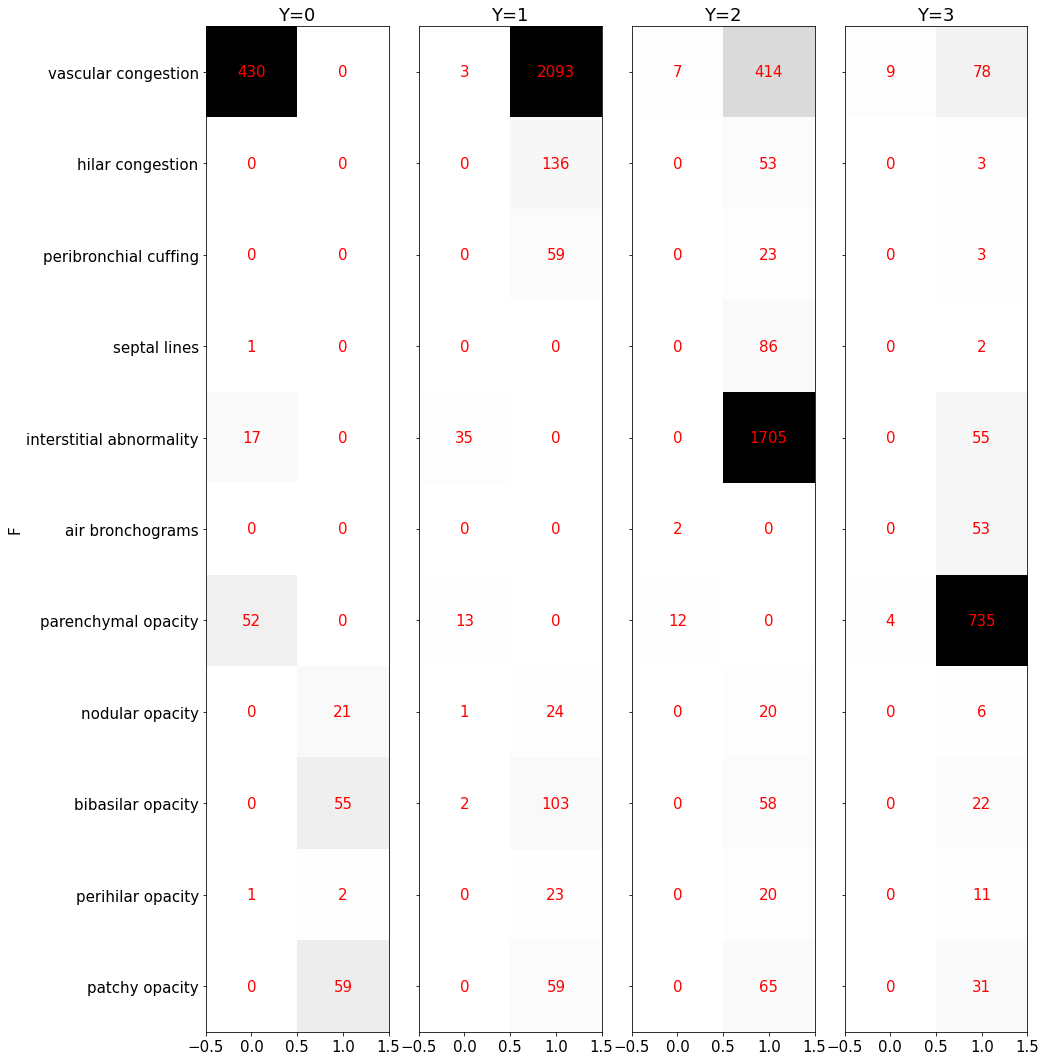

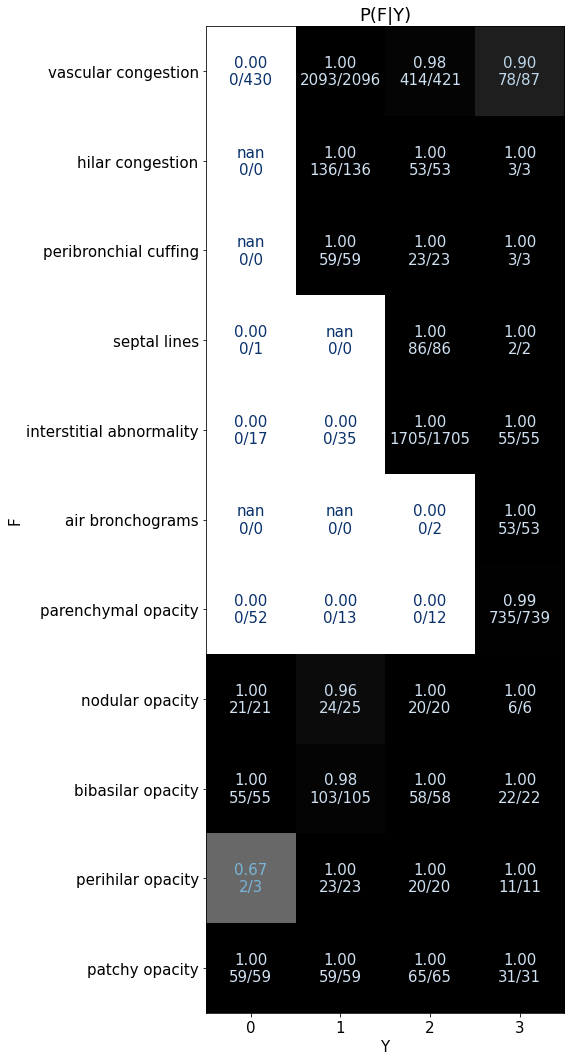

In [28]:
## plot correlation + FxY frequency
#
plt_correlation_and_frequency(df)

In [16]:
dfc = df.copy()
levels_findings = {
    0: ['acute cardiopulmonary process', 'fluid overload', 'vascular congestion', 'pulmonary edema'],
    1: ['vascular congestion', 'hilar congestion', 'peribronchial cuffing'],
    2: ['septal lines', 'interstitial abnormality'],
    3: ['parenchymal opacity', 'air bronchograms'],
}

In [17]:

for c in [2,1,0]:
    study_ids_withc = dfc[(dfc['regex_label']==c)&(df['study_id'].isin(chf_study_ids))]['study_id']
    print(f'c={c} (#studyid={len(study_ids_withc)})')

    # keywords_gt_lvlc = sum([v for k,v in levels_findings.items() if k>c], [])
    
    if c != 0:
        keywords_gt_lvlc = sum([v for k,v in levels_findings.items() if k>c], [])
    else:
        keywords_gt_lvlc = sum([v for k,v in levels_findings.items() if k>c], [])
        keywords_gt_lvlc = list(set(keywords_gt_lvlc)-set(['septal lines', 'air bronchograms']))

    def assign_zeros(row):
        for col in keywords_gt_lvlc:
            if np.isnan(row[col]):
                row[col] = 0
        return row
    
    dfc[dfc['study_id'].isin(study_ids_withc)] = \
        dfc[dfc['study_id'].isin(study_ids_withc)].apply(assign_zeros, axis=1)
    
# assign negatives for opacities 
    
C = cols_value_counts(dfc.iloc[:,1:])
for l in ["nodular opacity", "bibasilar opacity", "perihilar opacity", "patchy opacity"]:
    assert(C.loc[l,0<C.loc[l,1]])
    addn =  int(np.abs(C.loc[l,0] - C.loc[l,1])); addv = 0
    indices = dfc[dfc[l].isnull() & (dfc['acute cardiopulmonary process']==0)].index
    addIdx = np.random.choice(indices, size=addn, replace=False)
    dfc.iloc[addIdx, dfc.columns.get_loc(l)] = addv    

C = cols_value_counts(dfc.iloc[:,1:])
print(tabulate(C, headers=['findings'] + [str(x) for x in list(C.columns)]))

c=2 (#studyid=1750)
c=1 (#studyid=2253)
c=0 (#studyid=2586)
findings                         0.0    1.0    2.0    3.0     nan
-----------------------------  -----  -----  -----  -----  ------
pulmonary edema                26559  24334      0      0  164200
fluid overload                   147   2788      0      0  212158
acute cardiopulmonary process  27751    121      0      0  187221
vascular congestion            11201  16350      0      0  187542
hilar congestion                2602    912      0      0  211579
peribronchial cuffing           2590    829      0      0  211674
septal lines                    2263    410      0      0  212420
interstitial abnormality        5301   9320      0      0  200472
air bronchograms                4043    891      0      0  210159
parenchymal opacity             9350   7417      0      0  198326
nodular opacity                 2206   2206      0      0  210681
bibasilar opacity               5289   5289      0      0  204515
perihilar opacit

/data/vision/polina/shared_software/miniconda3/envs/cxr/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


(<Figure size 1080x576 with 1 Axes>,
 <Figure size 1080x1080 with 4 Axes>,
 <Figure size 1080x1080 with 1 Axes>)

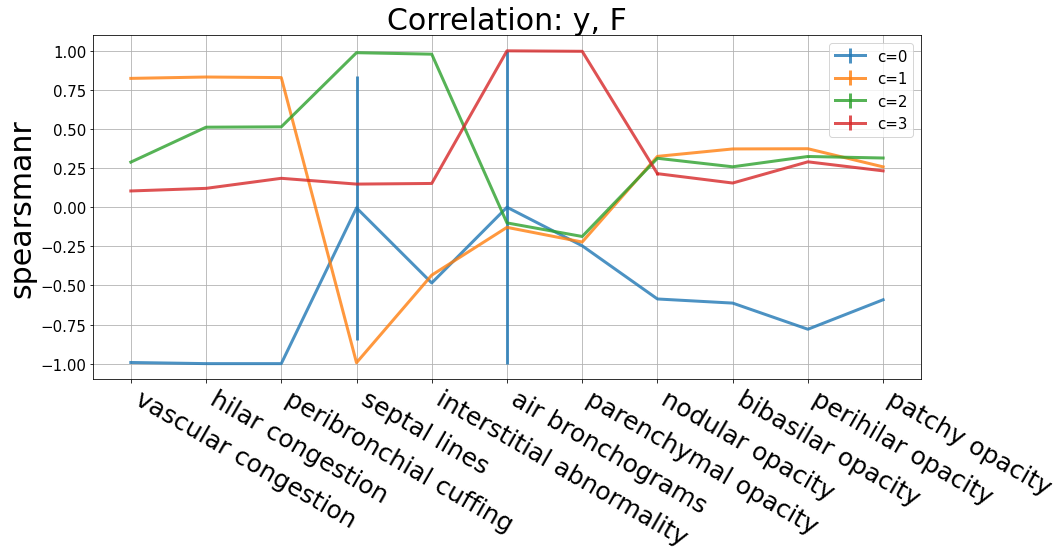

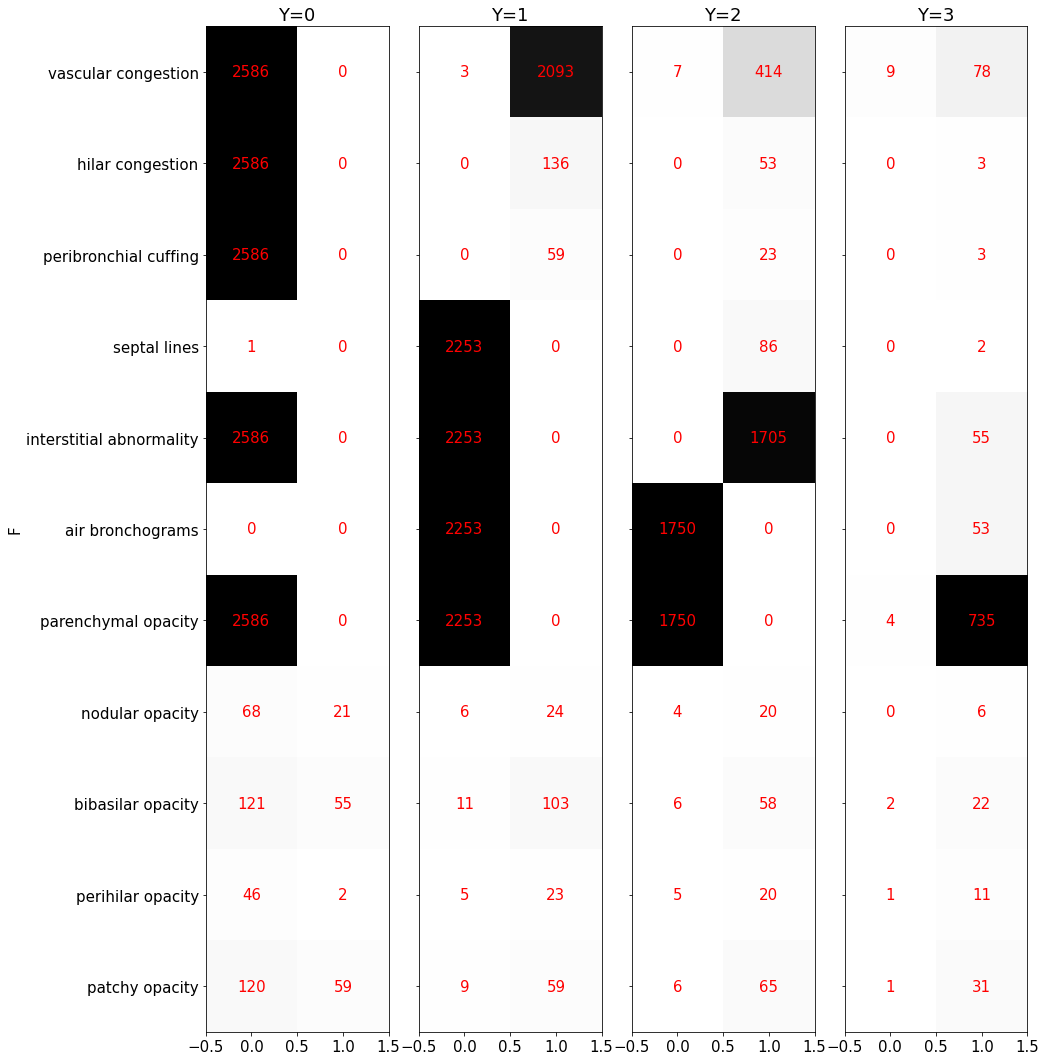

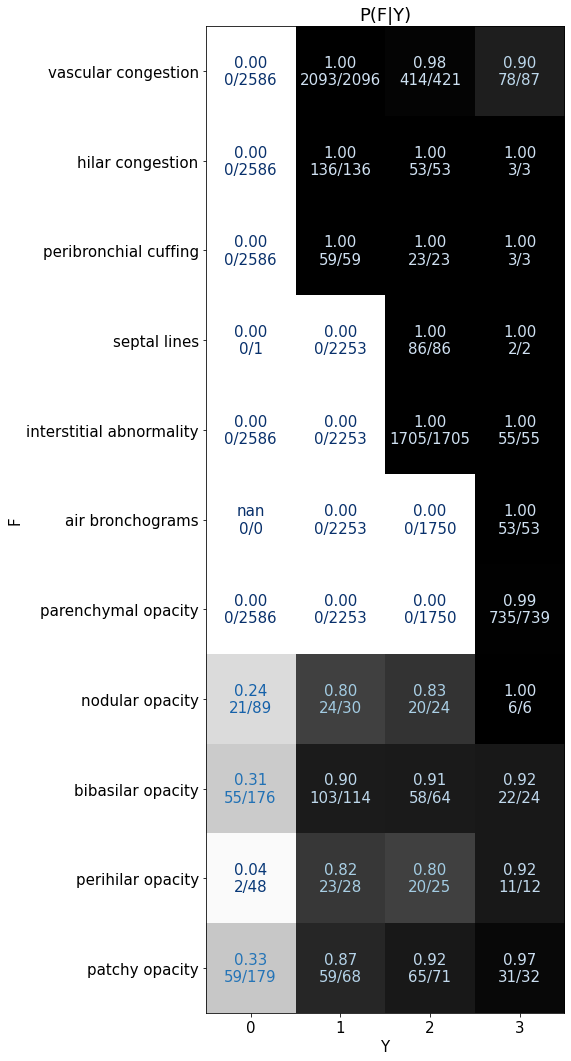

In [29]:
## plot correlation + FxY frequency
#
plt_correlation_and_frequency(dfc)

In [19]:
## - remove keywords used for assigning severity label but not as part of findings
#  - restrict chf cohort regex_label
# 
cols_drop = ['pulmonary edema',
             'fluid overload',
             'acute cardiopulmonary process',
             'severe pulmonary edema']

for col in cols_drop:
    if col in dfc.columns:
        dfc = dfc.drop(col, 1)
    
dfc['regex_label'][~dfc['study_id'].isin(chf_study_ids)] = np.nan


C = cols_value_counts(dfc.iloc[:,1:])
print(tabulate(C, headers=['findings'] + [str(x) for x in list(C.columns)]))

findings                    0.0    1.0    2.0    3.0     nan
------------------------  -----  -----  -----  -----  ------
vascular congestion       11201  16350      0      0  187542
hilar congestion           2602    912      0      0  211579
peribronchial cuffing      2590    829      0      0  211674
septal lines               2263    410      0      0  212420
interstitial abnormality   5301   9320      0      0  200472
air bronchograms           4043    891      0      0  210159
parenchymal opacity        9350   7417      0      0  198326
nodular opacity            2206   2206      0      0  210681
bibasilar opacity          5289   5289      0      0  204515
perihilar opacity          1579   1579      0      0  211935
patchy opacity             3850   3850      0      0  207393
regex_label                2586   2253   1750    895  207609


In [20]:

## save severity label

output_csv_path = f'regex_severity_v6.tsv'
dataset_output_csv_path = os.path.join('../../', 'notebooks', 'data', 'MimicCxrDataset', output_csv_path)

dfS = dfc[dfc['regex_label'].notnull()][['study_id','regex_label']]
dfS.to_csv(output_csv_path, sep="\t", index=False)
dfS.to_csv(dataset_output_csv_path, sep="\t", index=False)

dfS

,study_id,regex_label
15,54577367.0,0.0
17,54980801.0,0.0
21,59988438.0,0.0
302,50109051.0,1.0
304,51900145.0,2.0
...,...,...
215037,59159686.0,0.0
215057,54878259.0,3.0
215059,59281793.0,1.0
215060,59694089.0,1.0


In [21]:

## save findings

output_csv_path = f'regex_finding_v6.csv'
dataset_output_csv_path = os.path.join('../../', 'notebooks', 'data', 'MimicCxrDataset', output_csv_path)

dfF = dfc[['study_id']+info['finding']]
dfF.to_csv(dataset_output_csv_path, index=False)


dfF

,study_id,vascular congestion,hilar congestion,peribronchial cuffing,septal lines,interstitial abnormality,air bronchograms,parenchymal opacity,nodular opacity,bibasilar opacity,perihilar opacity,patchy opacity
0,50414267.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
1,53189527.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,53911762.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,56699142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,57375967.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
215088,58708861.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
215089,57132437.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
215090,55368167.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
215091,58621812.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
